# Course work: Intro to ML
## Objective: practice the preparation and modeling of data in order to predict the cancellation of hotel bookings
### Collaborative work by Giorgios, Pedro and Marius
### Data can be found at https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

## Step 1: importing libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost as xgb

## Inspection

In [4]:
# Displaying hidden columns
pd.set_option('display.max_columns', None) 

In [5]:
hotel= pd.read_csv("../input/hotel-booking-demand/hotel_bookings.csv")
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
hotel.shape

(119390, 32)

# Data Understanding

In [7]:
#Column names
print("Column Names:")
print(hotel.columns)

Column Names:
Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


## Describing the ambiguous columns, as documented on kaggle: 
- `hotel` : There are only two hotel types: Resort Hotel or City Hotel
- `is_canceled` : "Value indicating if the booking was canceled (1) or not (0)
- `lead_time`: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- `stays_in_weekend_nights`: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- `stays_in_week_nights`: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- `meal`: Type of meal booked. Categories are presented in standard hospitality meal packages: 
    - Undefined/SC – no meal package
    - BB – Bed & Breakfast
    - HB – Half board (breakfast and one other meal – usually dinner)
    - FB – Full board (breakfast, lunch and dinner)
- `country`: Country of origin. Categories are represented in the ISO 3155–3:2013 format
- `market_segment`: Market segment designation. 
    - “TA” means “Travel Agents”
    - “TO” means “Tour Operators”
- `distribution_channel`: Booking distribution channel. 
    - “TA” means “Travel Agents”
    - “TO” means “Tour Operators”
- `is_repeated_guest`: Value indicating if the booking name was from a repeated guest (1) or not (0)
- `previous_cancellations`: Number of previous bookings that were cancelled by the customer prior to the current booking
- `previous_bookings_not_canceled`: Number of previous bookings not cancelled by the customer prior to the current booking
- `reserved_room_type`: Code of room type reserved.
- `assigned_room_type`: Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request.
- `booking_changes`: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
- `deposit_type`: Indication on if the customer made a deposit to guarantee the booking. 
    - This variable can assume three categories: 
    - No Deposit – no deposit was made
    - Non Refund – a deposit was made in the value of the total stay cost
    - Refundable – a deposit was made with a value under the total cost of stay
- `agent`: ID of the travel agency that made the booking
- `company`: ID of the company/entity that made the booking or responsible for paying the booking.
- `days_in_waiting_list`: Number of days the booking was in the waiting list before it was confirmed to the customer
- `customer_type`: Type of booking, assuming one of four categories: 
    - Contract - when the booking has an allotment or other type of contract associated to it
    - Group – when the booking is associated to a group
    - Transient – when the booking is not part of a group or contract, and is not associated to other Transient parties
    - Transient Party - when the booking is transient, but is associated to at least other transient booking
- `adr`: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
- `required_car_parking_spaces`: Number of car parking spaces required by the customer
- `total_of_special_requests`: Number of special requests made by the customer (e.g. twin bed or high floor)
- `reservation_status`: Reservation last status, assuming one of three categories: 
    - Canceled – booking was canceled by the customer
    - Check-Out – customer has checked in but already departed
    - No-Show – customer did not check-in and did inform the hotel of the reason why
- `reservation_status_date`: Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel

## Data Cleansing

In [8]:

hotel.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [9]:
hotel.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


In [10]:
#Checking the missing values

hotel.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [11]:
#missing values as a percentage
null_values_percentage = (hotel.isnull().sum()/len(hotel))*100 
null_values_percentage

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.003350
babies                             0.000000
meal                               0.000000
country                            0.408744
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

In [12]:
#lets drop the column company 
hotel.drop(columns=['company'], inplace= True )

In [13]:
# beacause the percentage of nan values is really low lets errase the nana instances of this 2 columns
hotel.dropna(subset=  ['children','country'], inplace = True)

In [14]:
#since agent is a ID category we substitute the nan values with the mode
hotel.fillna(hotel['agent'].mode()[0], inplace = True)


In [15]:
# lets see if the nan values where handeled
hotel.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

We can therefore conclude that the data does not present significant missing values (defined as)

We continue to encoding, scaling and reformatting the data - ready for modeling.

### Handle inconsistencies and irrelevat features

In [16]:
# in some instances the stays_in_weekend_nights and stays_in_week_nights are both 0 that cant be by logic so we errase all record where this hapens
hotel = hotel[(hotel['stays_in_weekend_nights'] != 0) | (hotel['stays_in_week_nights'] != 0)]

In [17]:
# the column assigned_room_type dosent make sence in this problem because a room only is assigned on the check in day that means the boking is not canceled, so this is not a good predictor 
hotel.drop(columns=['assigned_room_type'], inplace= True )

In [18]:
#see if there is negative adr values
hotel[hotel['adr']<0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
14969,Resort Hotel,0,195,2017,March,10,5,4,6,2,0.0,0,BB,GBR,Groups,Direct,1,0,2,A,2,No Deposit,273.0,0,Transient-Party,-6.38,0,0,Check-Out,2017-03-15


In [19]:
# there is one negative adr value wich does not make sence Replace negative adr with median of adr column
hotel.loc[hotel['adr'] < 0, 'adr'] = hotel['adr'].median()

In [20]:
#from the descriptive statistics we see that the max of childeren and babys is 10 lets see how many instancies have this number 
len(hotel[hotel['children']==10]) , len(hotel[hotel['babies']==10] )

(1, 1)

In [21]:
# since we only have 1 instance for tose outliers children and babies, we will remove them from the data 
hotel = hotel[hotel['children'] != 10]
hotel = hotel[hotel['babies'] != 10]

#lets confirm if the noisy data was handeled
len(hotel[hotel['children']==10]) , len(hotel[hotel['babies']==10] ) ,len( hotel[hotel['adr']<0])

(0, 0, 0)

the columns reservation_status_date and reservation_status give us the same information as the target variable since the reservation status has 3 categories checked out, 

In [22]:
# lets see again what variables do we have
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118195 entries, 2 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118195 non-null  object 
 1   is_canceled                     118195 non-null  int64  
 2   lead_time                       118195 non-null  int64  
 3   arrival_date_year               118195 non-null  int64  
 4   arrival_date_month              118195 non-null  object 
 5   arrival_date_week_number        118195 non-null  int64  
 6   arrival_date_day_of_month       118195 non-null  int64  
 7   stays_in_weekend_nights         118195 non-null  int64  
 8   stays_in_week_nights            118195 non-null  int64  
 9   adults                          118195 non-null  int64  
 10  children                        118195 non-null  float64
 11  babies                          118195 non-null  int64  
 12  meal                 

## Feature engineering and feature selction starts here

In [23]:
# Copy hotel dataframe into a new one that will be engineered
hotel_eng = pd.DataFrame()
hotel_eng = hotel.copy()

In [24]:
# First lets start by transforming the months colum into a numerical one mapping the names of the months into the month number
month_to_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Map month names to month numbers using the dictionary
hotel_eng['arrival_date_month'] = hotel_eng['arrival_date_month'].map(month_to_number)

# Lets combine the 3 arrival colums into a single one named arrival_date 
hotel_eng['arrival_date'] = pd.to_datetime(hotel_eng['arrival_date_year'].astype(str) + '-' + 
                                    hotel_eng['arrival_date_month'].astype(str) + '-' + 
                                    hotel_eng['arrival_date_day_of_month'].astype(str))


In [25]:
hotel_eng.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,0,No Deposit,9.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01
5,Resort Hotel,0,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01
6,Resort Hotel,0,0,2015,7,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,0,No Deposit,9.0,0,Transient,107.0,0,0,Check-Out,2015-07-03,2015-07-01


In [26]:
# we now have the arrive month as a number the column, redundant with arrival_date_week_number so drop (strong correlation, bad for ML models input)
hotel_eng.drop(columns=['arrival_date_week_number'], inplace= True )


In [27]:
#show the categories in the reservation_status
hotel_eng['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

The columns reservation_status and reservation_status_date should not be used to predict whether the booking will be canceled or not because the contain direct information about the dependent variable. Using this columns to do predictions will result in a massive data leakage. 

For that reason those columns will be droped.

In [28]:
# droping the 2 columns mentioned above

hotel_eng.drop(columns=['reservation_status','reservation_status_date'], inplace= True )


# Exploratory Data Analysis

In [29]:
hotel_eng.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'arrival_date'],
      dtype='object')

### Trend of Cancellation rate in time

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


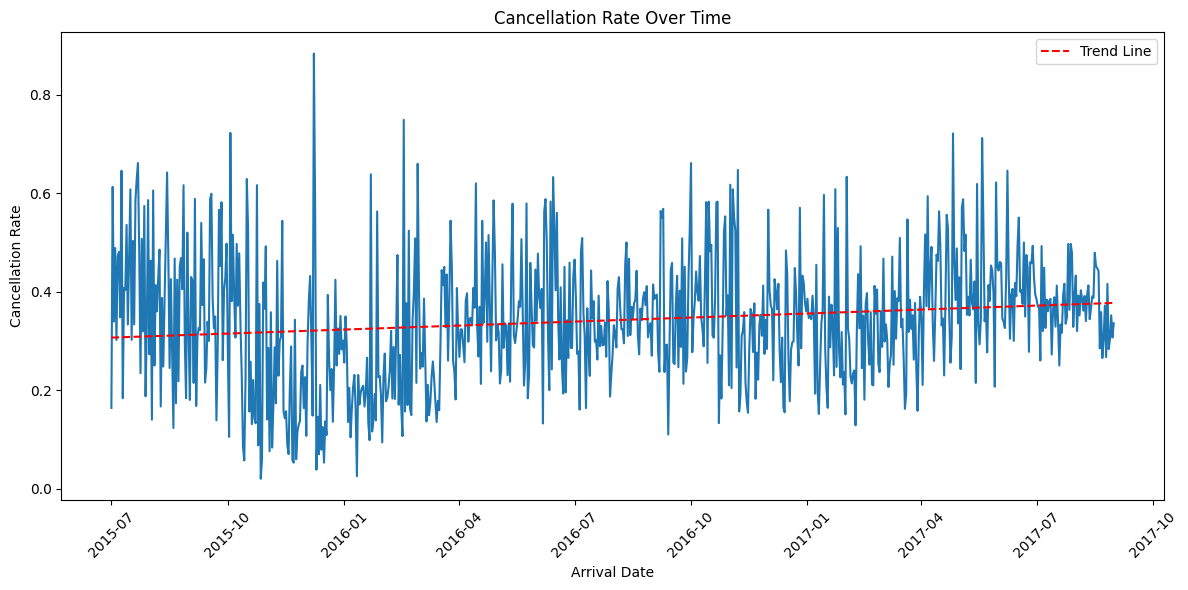

In [30]:
# showing the cancelation rate to have a notion of the structure 
cancellation_rate_by_date = hotel_eng.groupby('arrival_date')['is_canceled'].mean()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=cancellation_rate_by_date.index, y=cancellation_rate_by_date.values)

# Fit a trend line (linear regression)
trend_x = np.arange(len(cancellation_rate_by_date))
trend_y = np.poly1d(np.polyfit(trend_x, cancellation_rate_by_date.values, 1))(trend_x)
plt.plot(cancellation_rate_by_date.index, trend_y, color='red', linestyle='--', label='Trend Line')

plt.title('Cancellation Rate Over Time')
plt.xlabel('Arrival Date')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Cancelation distribution

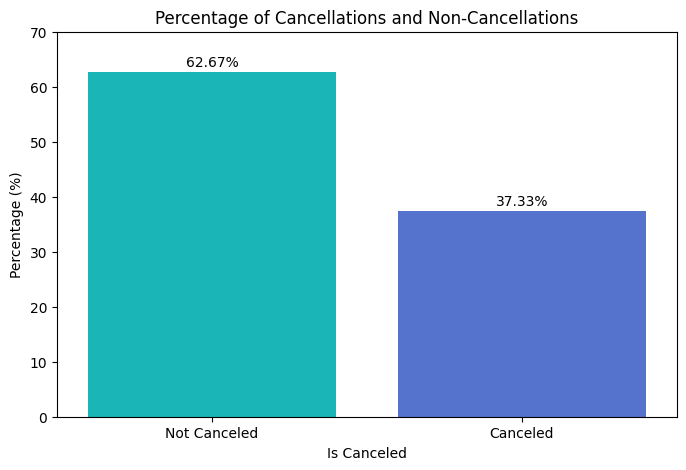

In [31]:
# Calculating the percentage of each class
percentage = hotel_eng['is_canceled'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=['darkturquoise', 'royalblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

In [32]:
hotel_eng.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'arrival_date'],
      dtype='object')

### TODO: Clarify why moving to new data frame now. 

now that we have visualized the data by date we can drop the columns arrival_date_year beacause we only have 3 years and our objective is not to do a time searies analisis is to predict if a booking wil be canceled or not so including this feature will introduce bias in future prediction by extention the column arrival_date also contais the year so ww will drop it as well

In [33]:
hotel_eng_ny=hotel_eng.drop(columns=['arrival_date','arrival_date_year'],axis=1)

In [34]:
#lets select the categorical coluns to make some count plots
hotel_eng_ny_cat = hotel_eng_ny.select_dtypes(include=['object'])
hotel_eng_ny_cat

,hotel,meal,country,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type
2,Resort Hotel,BB,GBR,Direct,Direct,A,No Deposit,Transient
3,Resort Hotel,BB,GBR,Corporate,Corporate,A,No Deposit,Transient
4,Resort Hotel,BB,GBR,Online TA,TA/TO,A,No Deposit,Transient
5,Resort Hotel,BB,GBR,Online TA,TA/TO,A,No Deposit,Transient
6,Resort Hotel,BB,PRT,Direct,Direct,C,No Deposit,Transient
...,...,...,...,...,...,...,...,...
119385,City Hotel,BB,BEL,Offline TA/TO,TA/TO,A,No Deposit,Transient
119386,City Hotel,BB,FRA,Online TA,TA/TO,E,No Deposit,Transient
119387,City Hotel,BB,DEU,Online TA,TA/TO,D,No Deposit,Transient
119388,City Hotel,BB,GBR,Online TA,TA/TO,A,No Deposit,Transient


### Split into `categorical` and `numerical` dataframes

In [35]:
# Drop non-numerical variables
hotel_eng_ny_num=hotel_eng_ny.drop(columns=hotel_eng_ny_cat.columns )
hotel_eng_ny_num

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
2,0,7,7,1,0,1,1,0.0,0,0,0,0,0,9.0,0,75.00,0,0
3,0,13,7,1,0,1,1,0.0,0,0,0,0,0,304.0,0,75.00,0,0
4,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.00,0,1
5,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.00,0,1
6,0,0,7,1,0,2,2,0.0,0,0,0,0,0,9.0,0,107.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,8,30,2,5,2,0.0,0,0,0,0,0,394.0,0,96.14,0,0
119386,0,102,8,31,2,5,3,0.0,0,0,0,0,0,9.0,0,225.43,0,2
119387,0,34,8,31,2,5,2,0.0,0,0,0,0,0,9.0,0,157.71,0,4
119388,0,109,8,31,2,5,2,0.0,0,0,0,0,0,89.0,0,104.40,0,0


### Count plot for key `categorical` Columns

### TODO: fix scaling and fix 3x2 master grid.

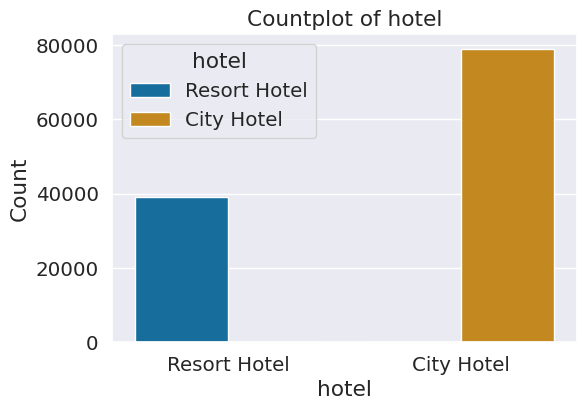

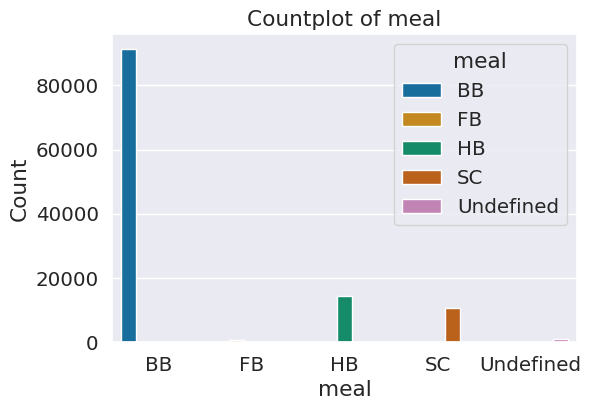

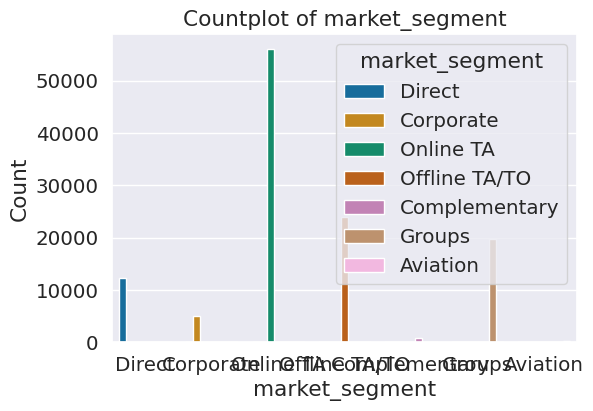

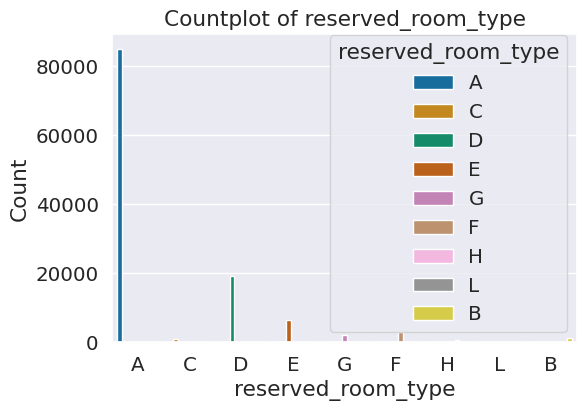

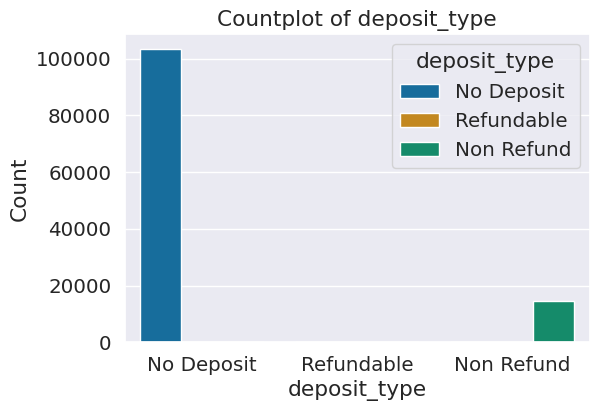

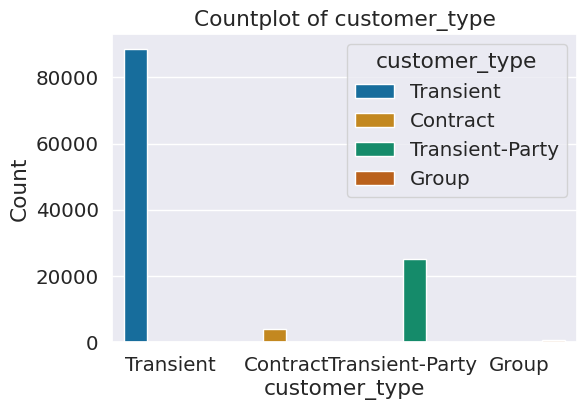

In [36]:
# Make and visualize the countplots
countplots = []
plots = ["hotel", "meal", "market_segment", "reserved_room_type", "deposit_type", "customer_type"]

sns.set(font_scale=1.3)

# Iterate over each column in the DataFrame
for column in plots:
    # Create a new figure and axes for each plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot the countplot for the current column
    sns.countplot(data=hotel_eng_ny_cat, x=column, ax=ax, palette="colorblind", hue = column)
    
    # Set the title and labels for the plot
    ax.set_title(f"Countplot of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Count")
    
    # Show the plot
    plt.show()





### Histograms for `numerical` Columns

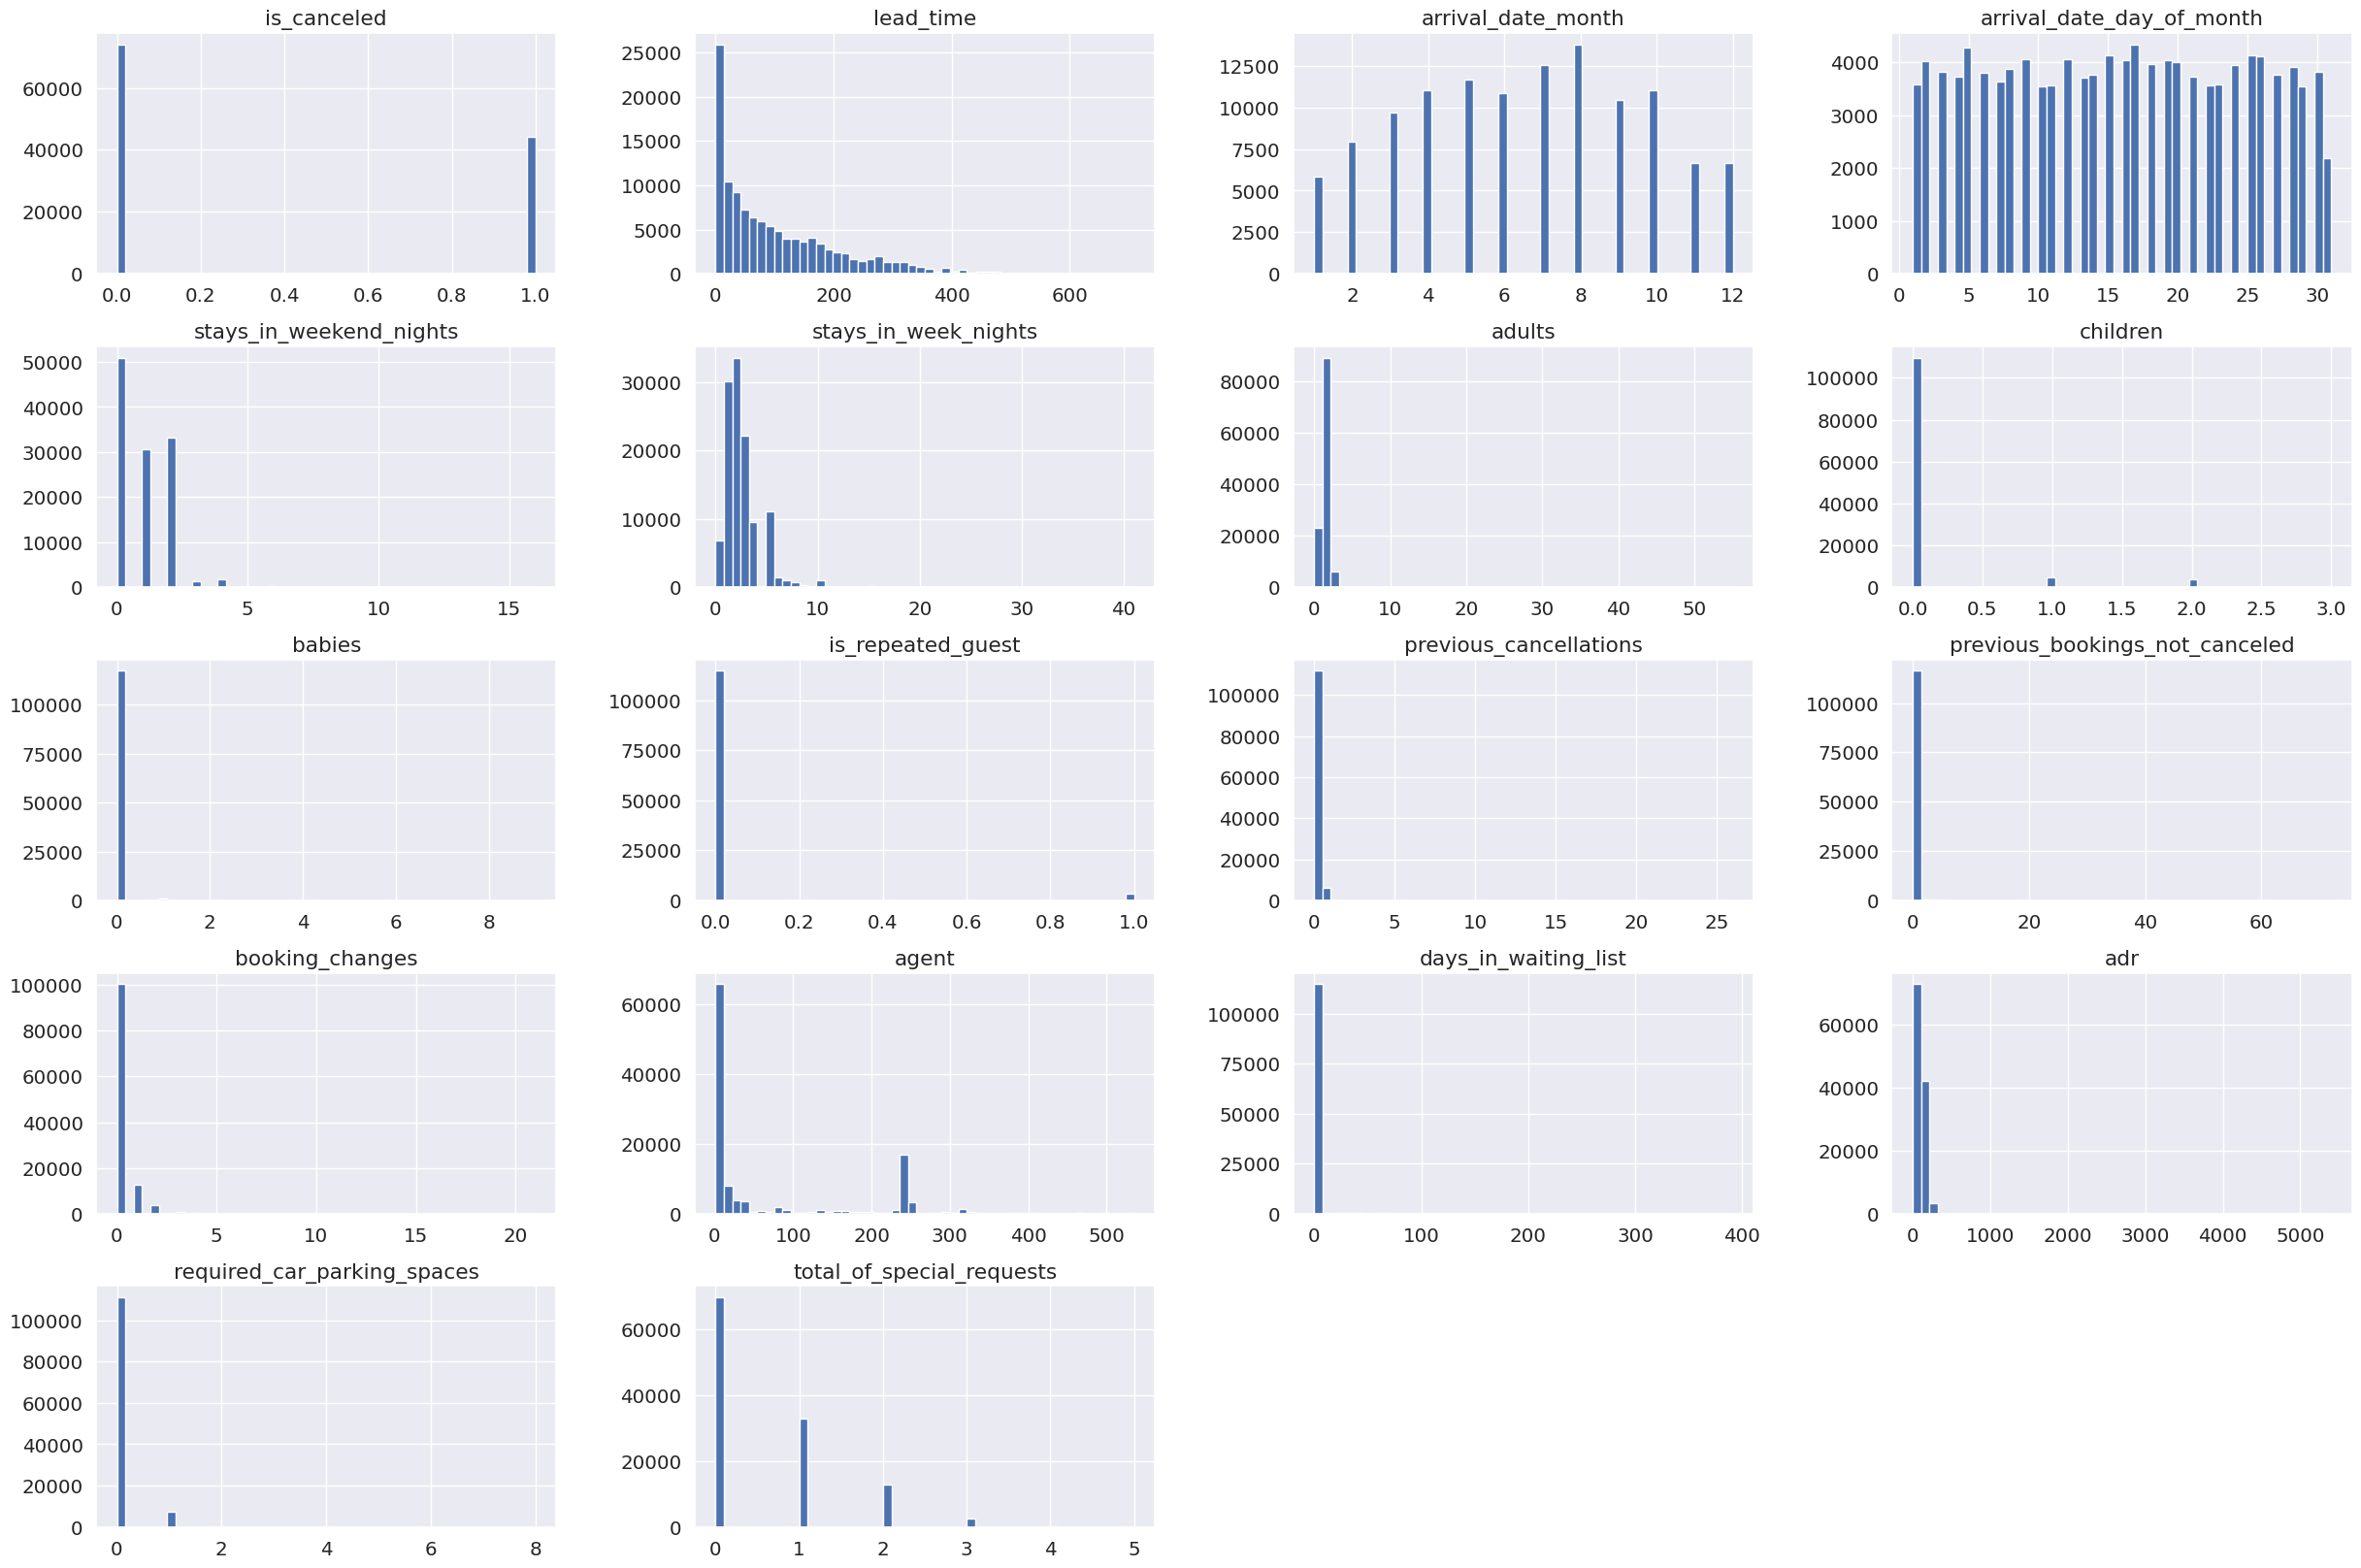

In [37]:
#now lets make some histograms for the numerical variables
hotel_eng_ny_num.hist(bins=50, figsize=(30,20))
plt.show()

#### Observations:

* Much more city hotels that resort hotels
* Most reservations made near the date of the check in. (small lead time)
* Most bookings were made in 2016. 
* June and July are the busiest months, by a small margin.
* Most bookings have 2 adults, no babies or children.
* Most guests are new, and they usually don't have previous cancellations.
* Usually, there are no booking_changes
* Days in waiting list are mostly 0

In [38]:
hotel_eng_ny_num.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
2,0,7,7,1,0,1,1,0.0,0,0,0,0,0,9.0,0,75.0,0,0
3,0,13,7,1,0,1,1,0.0,0,0,0,0,0,304.0,0,75.0,0,0
4,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1
5,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1
6,0,0,7,1,0,2,2,0.0,0,0,0,0,0,9.0,0,107.0,0,0


### The correlation matrix does not uncover any clear links:

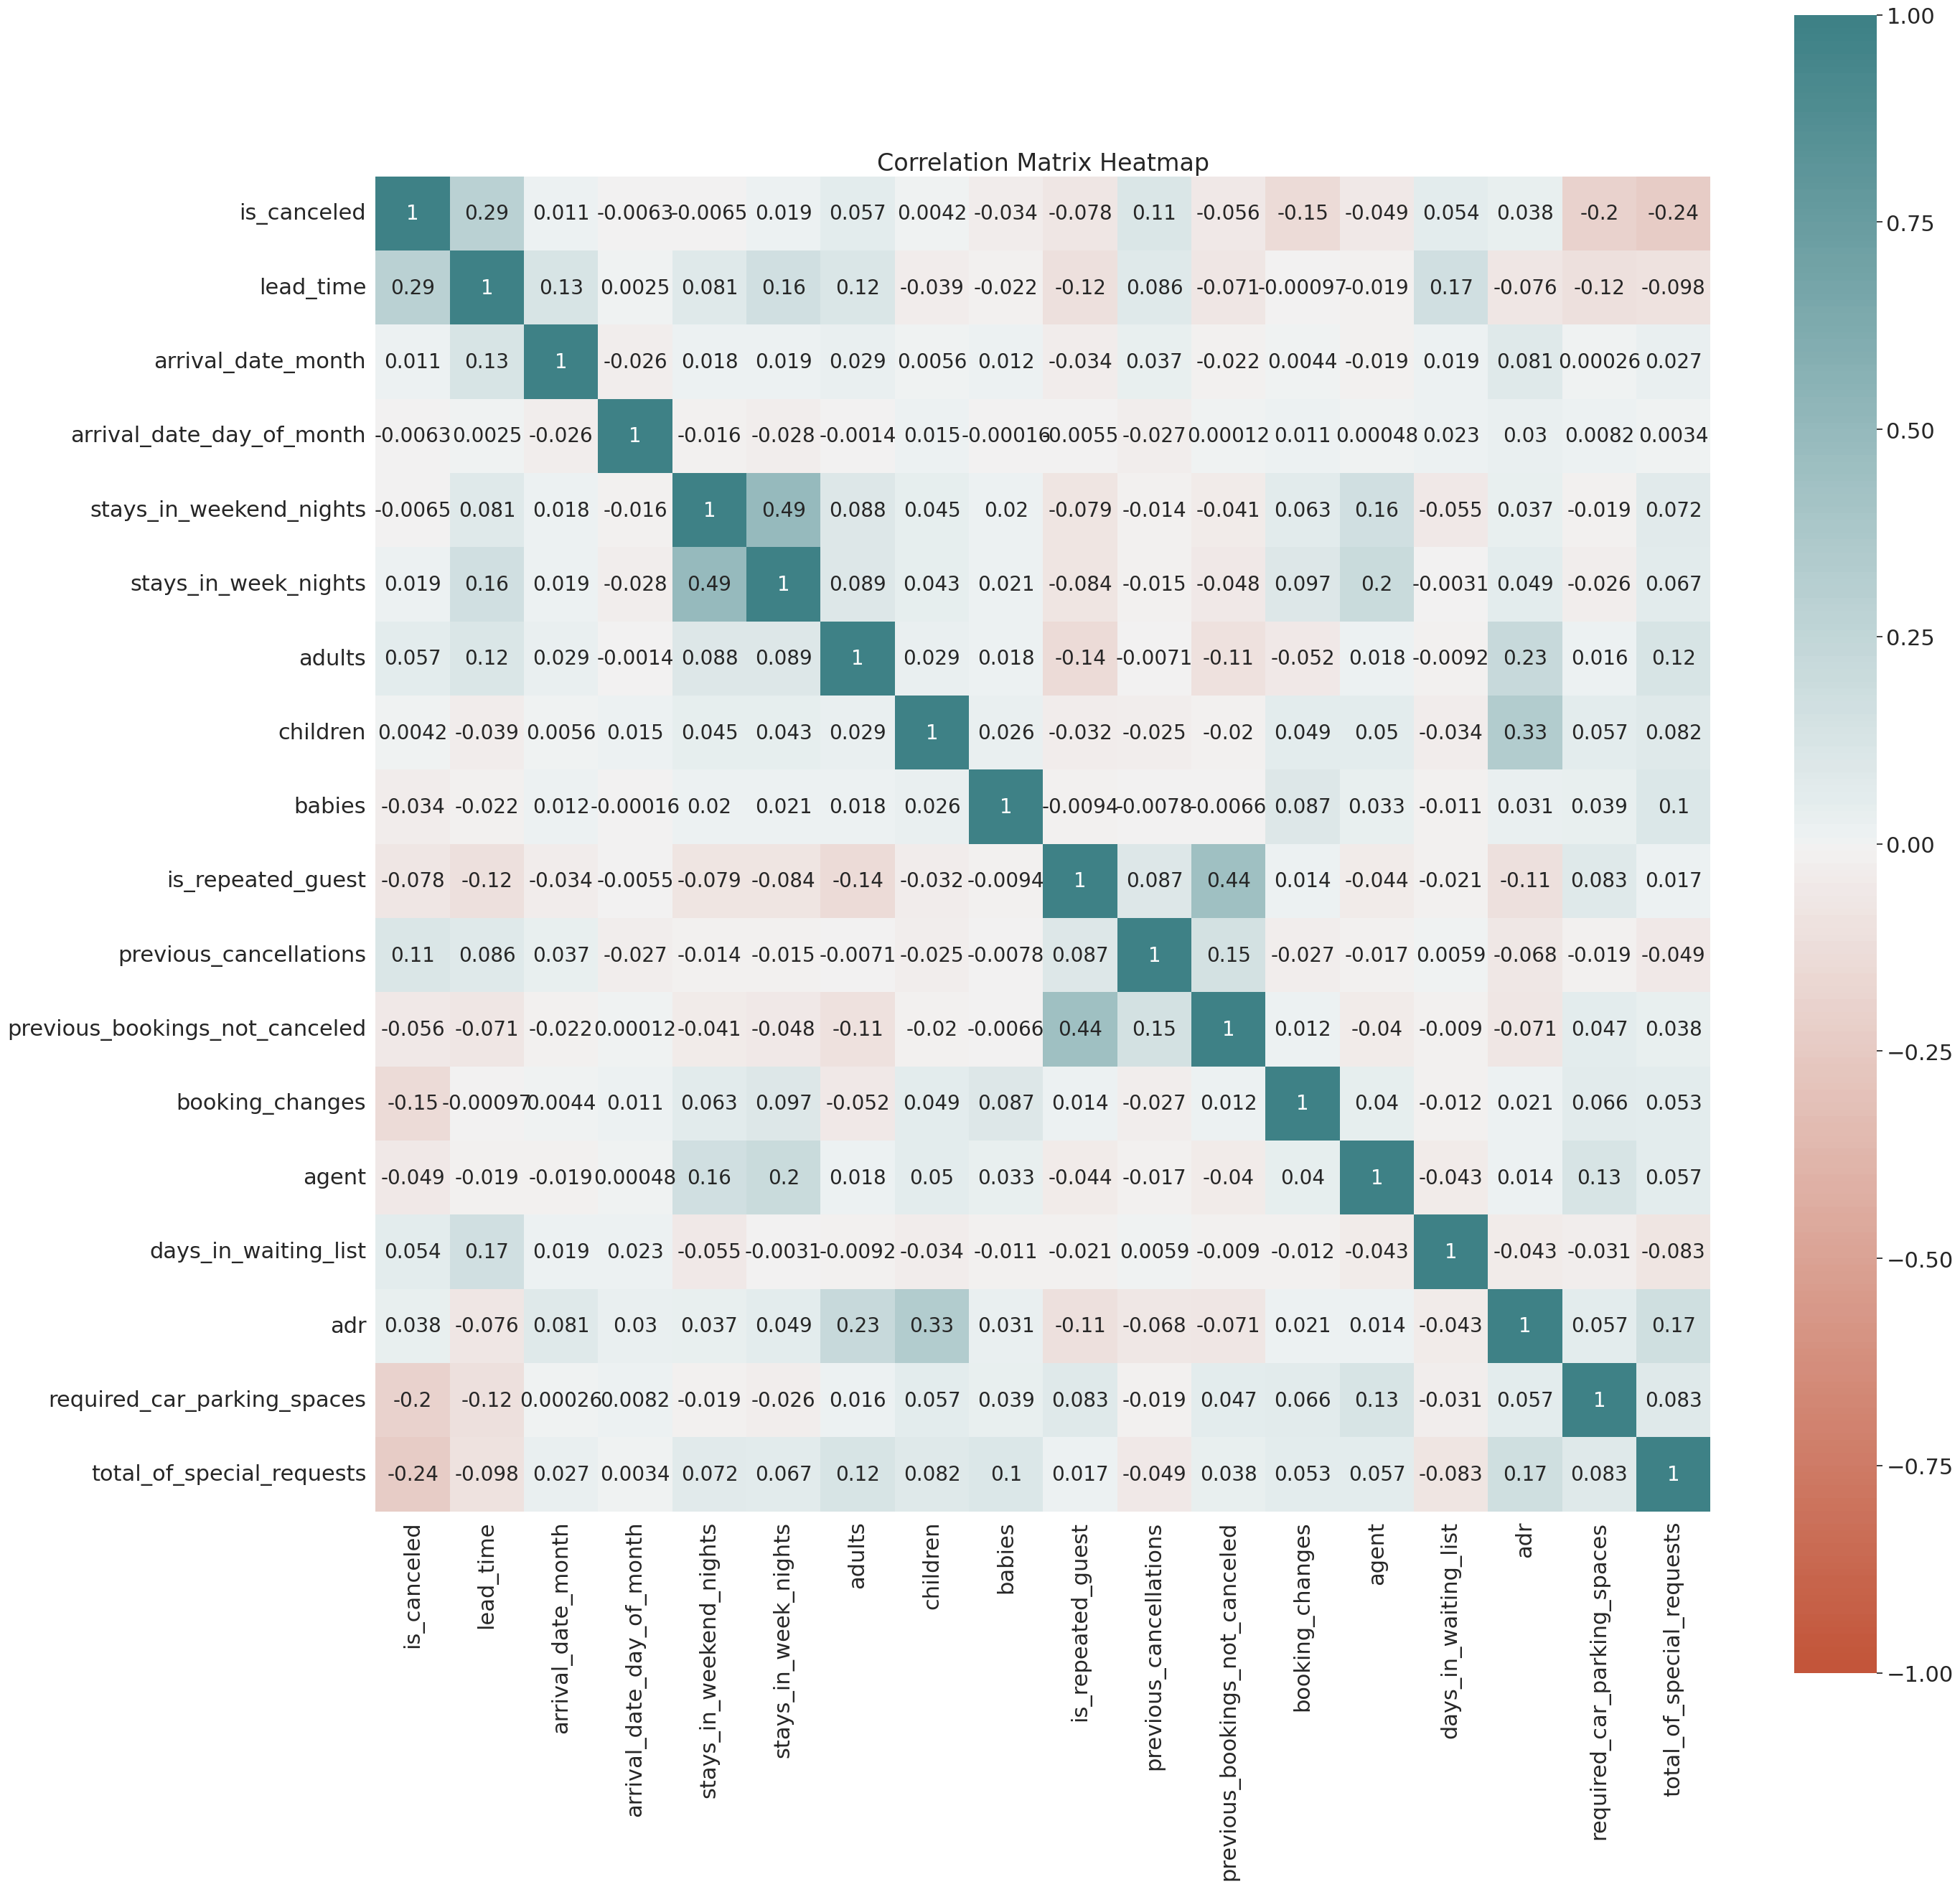

In [39]:
# Plot correlation matrix
cormat = hotel_eng_ny_num.corr()

plt.figure(figsize=(30, 30))
sns.set(font_scale=2.0)
ax = sns.heatmap(
    cormat,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 200, n=200),
    square=True, annot=True, annot_kws={'size': 20}
)
plt.title('Correlation Matrix Heatmap', fontsize=24)
plt.show()

## Data preparation: encoding of `categorical` columns

In [40]:
#descriptive stats from the cat variables
hotel_eng_ny_cat.describe().T



,count,unique,top,freq
hotel,118195,2,City Hotel,78977
meal,118195,5,BB,91316
country,118195,177,PRT,47990
market_segment,118195,7,Online TA,56090
distribution_channel,118195,5,TA/TO,97265
reserved_room_type,118195,9,A,85084
deposit_type,118195,3,No Deposit,103460
customer_type,118195,4,Transient,88580


`country` has 177 unique values, with the vast majority PRT. This means that the encoder a huge amount of columns without introducing relevant information for the model. For that reason we will drop this column:

In [41]:
# drop country as encoding it does not introduce information for the models
hotel_eng_ny_cat.drop(columns=['country'],inplace=True)

In [42]:
hotel_eng_ny_cat

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type
2,Resort Hotel,BB,Direct,Direct,A,No Deposit,Transient
3,Resort Hotel,BB,Corporate,Corporate,A,No Deposit,Transient
4,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient
5,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient
6,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient
...,...,...,...,...,...,...,...
119385,City Hotel,BB,Offline TA/TO,TA/TO,A,No Deposit,Transient
119386,City Hotel,BB,Online TA,TA/TO,E,No Deposit,Transient
119387,City Hotel,BB,Online TA,TA/TO,D,No Deposit,Transient
119388,City Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient


Encode some nominal columns:

`hotel`, `meal`, `market_segment`, `distribution_channel`, `reserved_room_type`, `deposit_type`, `customer_type`

In [43]:
#encode the dummies
X_encoded=pd.get_dummies(hotel_eng_ny_cat)

#replace space with '-'
X_encoded.columns = X_encoded.columns.str.replace(' ', '-')


In [44]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118195 entries, 2 to 119389
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   hotel_City-Hotel                118195 non-null  bool 
 1   hotel_Resort-Hotel              118195 non-null  bool 
 2   meal_BB                         118195 non-null  bool 
 3   meal_FB                         118195 non-null  bool 
 4   meal_HB                         118195 non-null  bool 
 5   meal_SC                         118195 non-null  bool 
 6   meal_Undefined                  118195 non-null  bool 
 7   market_segment_Aviation         118195 non-null  bool 
 8   market_segment_Complementary    118195 non-null  bool 
 9   market_segment_Corporate        118195 non-null  bool 
 10  market_segment_Direct           118195 non-null  bool 
 11  market_segment_Groups           118195 non-null  bool 
 12  market_segment_Offline-TA/TO    118195 non-null  

### Combine the `numerical` and encoded `categorical` dataframes

### TODO: rename data to something more explanatory.

In [45]:
# combining the numerical colums with the encoded variables

data = hotel_eng_ny_num.join(X_encoded, lsuffix='_left', rsuffix='_right')

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118195 entries, 2 to 119389
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118195 non-null  int64  
 1   lead_time                       118195 non-null  int64  
 2   arrival_date_month              118195 non-null  int64  
 3   arrival_date_day_of_month       118195 non-null  int64  
 4   stays_in_weekend_nights         118195 non-null  int64  
 5   stays_in_week_nights            118195 non-null  int64  
 6   adults                          118195 non-null  int64  
 7   children                        118195 non-null  float64
 8   babies                          118195 non-null  int64  
 9   is_repeated_guest               118195 non-null  int64  
 10  previous_cancellations          118195 non-null  int64  
 11  previous_bookings_not_canceled  118195 non-null  int64  
 12  booking_changes      

In [47]:
data.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City-Hotel,hotel_Resort-Hotel,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline-TA/TO,market_segment_Online-TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No-Deposit,deposit_type_Non-Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
2,0,7,7,1,0,1,1,0.0,0,0,0,0,0,9.0,0,75.0,0,0,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
3,0,13,7,1,0,1,1,0.0,0,0,0,0,0,304.0,0,75.0,0,0,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
4,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
5,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
6,0,0,7,1,0,2,2,0.0,0,0,0,0,0,9.0,0,107.0,0,0,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False


### Independent and target variables split.

In [48]:
#now we need to divide the data into y (target variable ) and X independent variables
y = data['is_canceled']
y

2         0
3         0
4         0
5         0
6         0
         ..
119385    0
119386    0
119387    0
119388    0
119389    0
Name: is_canceled, Length: 118195, dtype: int64

In [49]:
X=  data.drop('is_canceled', axis=1)

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118195 entries, 2 to 119389
Data columns (total 52 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       118195 non-null  int64  
 1   arrival_date_month              118195 non-null  int64  
 2   arrival_date_day_of_month       118195 non-null  int64  
 3   stays_in_weekend_nights         118195 non-null  int64  
 4   stays_in_week_nights            118195 non-null  int64  
 5   adults                          118195 non-null  int64  
 6   children                        118195 non-null  float64
 7   babies                          118195 non-null  int64  
 8   is_repeated_guest               118195 non-null  int64  
 9   previous_cancellations          118195 non-null  int64  
 10  previous_bookings_not_canceled  118195 non-null  int64  
 11  booking_changes                 118195 non-null  int64  
 12  agent                

In [51]:
# now split the data into train and test caution since we have a 63% not canceled and 37% canceled we used the stratify=y parameter  it ensures that the class distribution in the original dataset is preserved  both the training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)

### TODO: Rewrite and edit based on team decisions and report performance metrics.

now we pass to the models. in this section the metric we will pay the moast attention is the f1 score , this is due to f1 score being the harmonic mean between precision and recall the two metrics that we are more woried about. 

out target variable is_canceled  indicates wether a booking was canceled (1) or not (0) so false positives( boking is predicted as canceled but is not ) and false negatives(booking is predicted to not be canceled but it is)  are pretty inportant  but the false negatives may cost more to the hotel because they will lose potential costumers, thinking the rooms will be ocupied but will not. so a good way to minimize the false negatives is to maximize recal Recall= True Positives /(True Positives+False Negatives)
but maximizing precision, ( precision = true Positives/(True Positives + False Positives)) is also important since the false positives can have in the long run a more devastating  im pact in hotel imagige and reputation thus profitability, this is because , assuming that the hotel opperates in full cappacity and predicts that a costumer will cancel the booking and sell the room to another costumer then one of the costumers will not have a room  and the hotel may incur in heavy finnes so  our desicion is to maximize the f1 score being that 
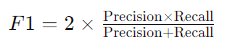


a table was created to better vizulize the impacts  of TP,TN,FP,FN

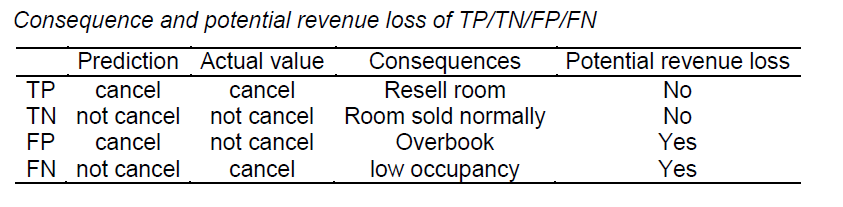


## House keeping: defining reusable functions 💪

### Reusable function for hyper parameter optimization:

In [52]:

def tune_clf_hyp_param_scal(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5, scaler=False):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score  is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    It also includes standardization for numerical variables in the training data.
    '''
    
    # Identify numerical features (excluding boolean)
    numerical_features = X_train.select_dtypes(exclude=[bool]).columns.tolist()

    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    if scaler:
        # Create a pipeline for preprocessing (standardization) and modeling
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardization for numerical features
            ('clf', clf)  # Classifier
        ])

        # Create the GridSearchCV object
        clf_grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    else:
        # Create the GridSearchCV object
        clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

   
    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

### Reusable functions for metrics, evaluation:

In [53]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated .
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision','Recall ','F1-score ','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [54]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data ')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

# ML Models

## 1. Logistic regression

Logistic regression is a statistical model that is popular and widely used in machine learning. It has several strengths:

**Interpretability**: Logistic regression provides interpretable coefficients that can be used to understand the impact of each feature on the predicted outcome. These coefficients can help identify the most important features in the classification task.

**Probability estimation**: Logistic regression models provide probability estimates for each class, allowing for a more nuanced understanding of the predicted outcomes. This can be useful in scenarios where the decision threshold needs to be adjusted based on the specific requirements of the problem.

In binary classification tasks, logistic regression performs well when the relationship between the features and the target variable is approximately linear. It assumes a linear decision boundary and works best when the classes are well-separated and the data is linearly separable. Logistic regression can handle both continuous and categorical features, making it versatile for a wide range of datasets.

However, logistic regression may not perform well in scenarios where the relationship between the features and the target variable is highly non-linear or when there are complex interactions between the features. In such cases, more advanced algorithms like decision trees, random forests, or neural networks may be more suitable.

We will therefore use it as a baseline, for comparison purposes.


In [55]:
# Base Logistic Regression model
lr_base= LogisticRegression(random_state=42, n_jobs=-1) 

### TODO: to enable for report archive.

In [56]:
# Hyperparameter grid for LR
""" param_grid_lr = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg'],
    'clf__max_iter': [50, 100, 200, 500]
}
"""

" param_grid_lr = {\n    'clf__penalty': ['l1', 'l2'],\n    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],\n    'clf__solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg'],\n    'clf__max_iter': [50, 100, 200, 500]\n}\n"

In [57]:
# Hyperparameter grid for LR
param_grid_lr = {
    'clf__penalty': ['l2'],
    'clf__C': [10],
    'clf__solver': ['lbfgs'],
    'clf__max_iter': [50]
}


In [58]:
# Using the tune_clf_hyp_param_scal function to get the best estimator
best_lr, best_lr_hyperparams = tune_clf_hyp_param_scal(lr_base, param_grid_lr, X_train, y_train, scaler=True)
print('LR Optimal Hyperparameters: \n', best_lr_hyperparams)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LR Optimal Hyperparameters: 
 {'clf__C': 10, 'clf__max_iter': 50, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     59255
           1       0.84      0.60      0.70     35301

    accuracy                           0.81     94556
   macro avg       0.82      0.77      0.78     94556
weighted avg       0.81      0.81      0.80     94556


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     14814
           1       0.83      0.60      0.70      8825

    accuracy                           0.81     23639
   macro avg       0.81      0.76      0.78     23639
weighted avg       0.81      0.81      0.80     23639



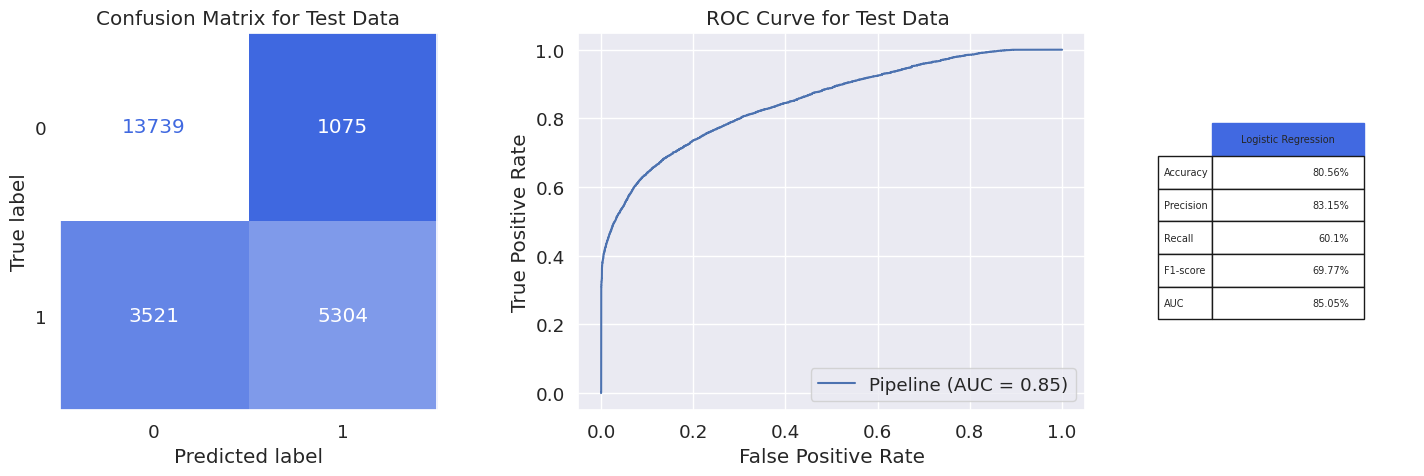

In [59]:
model_evaluation(best_lr, X_train, X_test, y_train, y_test, 'Logistic Regression')

In [60]:
# save the results of the rf moedel to further comparison
lr_result = metrics_calculator(best_lr, X_test, y_test, 'Logistic Regression')
lr_result

,Logistic Regression
Accuracy,80.56%
Precision,83.15%
Recall,60.1%
F1-score,69.77%
AUC,85.05%


### Analysis

**Accuracy** ``81%`` -  the correct predictions out of total predictions are 81% 

**Precision** ``83%`` - the instances that the model predicted as canceled which where actually canceled is 83%

**Recal** ``60%`` -  the model correctly identified only 60% of all true cancelations

**F1** ``70%`` - the harmonic mean between precision and recall is 70%

**AUC** ``85%`` - good performance in distinguishing capability between the 2 classes 

So far, the tree based models performed better.

## 2. Decision tree

Intro: based on research papers, Tree models offer great performance for binary classification challenges, as described in our report.

Decision trees in particular, have the following advantages:

1. **Good accuracy**: This means that the tree is able to capture the underlying patterns and relationships in the data well enough.

2. **Performance**: relatively fast, on a personal computer, and scales well with our dataset size (10k entries and ~200 encoded columns)

3. **Interpretable**: Decision trees are known for their interpretability. A strong decision tree should be easy to understand and interpret, allowing users to gain insights into the decision-making process.


To get the most out of decision trees while not overfitting, we followed the following techniques:

**Hyperparameter Tuning**:
   - **max_depth**: The maximum depth of the tree. Higher values can lead to overfitting, while lower values can result in underfitting.
   - **min_samples_split**: The minimum number of samples required to split an internal node. Higher values can prevent overfitting.
   - **min_samples_leaf**: The minimum number of samples required to be at a leaf node. Higher values can prevent overfitting.
   - **max_features**: The number of features to consider when looking for the best split. Lower values can reduce overfitting.
   - **criterion**: The function to measure the quality of a split. "gini" or "entropy" can be used. Experiment with both to see which works better for your data.

Used **GridSearchCV** from the scikit-learn library to search through different combinations of hyperparameters and find the best ones. These techniques perform cross-validation to evaluate the model's performance on different subsets of the data.

**Regularization**: Regularized the decision tree model to prevent **overfitting**. This can be done by setting constraints on the tree's structure, such as limiting the maximum depth or the minimum number of samples required for a split.

**Evaluated Performance**: After training the decision tree with the optimized hyperparameters, evaluated its performance using appropriate evaluation metrics such as accuracy, precision, recall, or F1-score. Additionally, used techniques like cross-validation to get a more reliable estimate of the model's performance.



In [61]:
dt_base = DecisionTreeClassifier(random_state=42) # Base Decision Tree model

### TODO: to enable for report archive.

In [62]:
# Hyperparameter grid for DT
""" 
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
   
}
"""

" \nparam_grid_dt = {\n    'criterion': ['gini', 'entropy'],\n    'max_depth': [13, 14, 15],\n    'min_samples_split': [2, 3, 4],\n    'min_samples_leaf': [1, 2, 3],\n   \n}\n"

In [63]:
# Code for running the notebook fast in Kaggle or locally / bypass grid search for best hyper parameters
param_grid_dt = {'criterion': ['gini'], 'max_depth': [15], 'min_samples_leaf': [1], 'min_samples_split': [3]}

In [64]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyp_param_scal(dt_base, param_grid_dt, X_train, y_train)
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     59255
           1       0.86      0.74      0.80     35301

    accuracy                           0.86     94556
   macro avg       0.86      0.83      0.84     94556
weighted avg       0.86      0.86      0.86     94556


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     14814
           1       0.82      0.71      0.76      8825

    accuracy                           0.83     23639
   macro avg       0.83      0.81      0.82     23639
weighted avg       0.83      0.83      0.83     23639



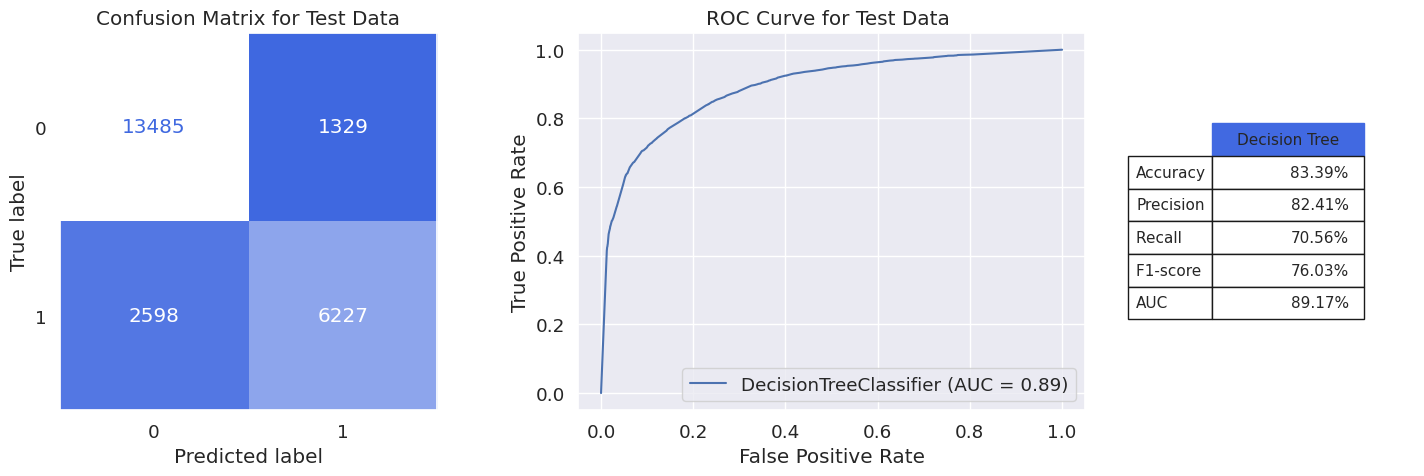

In [65]:
# evaluate and report
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree') 

In [66]:
# save the results of this model 
dt_result = metrics_calculator(best_dt, X_test, y_test, 'Decision Tree')
dt_result

,Decision Tree
Accuracy,83.39%
Precision,82.41%
Recall,70.56%
F1-score,76.03%
AUC,89.17%


### Analysis 

**Acuracy** ``86%``  - meaning that 86% of all predictions were correct
 
**Precision** ``82%`` - the model correctly predicted 82% of cancellations, while 18% of predicted cancellations did not in fact take place
 
**Recall** ``71%`` - the model predicted that the guest will come, while in fact they cancelled - 29% of the time

**F1-score** for class 1 is ``76%`` - which is the harmonic mean of Precision and Recall - our main metric of interest.

**AUC (Area Under the ROC Curve)** for class 1 is 89%, which means that the model has a good discriminative power between the two classes.


We can confidently say that the model is **not overfitting**, as the metrics for the test set and the traian set are close. This is further confirmed by using cross validation (kfold).

### Feature importance

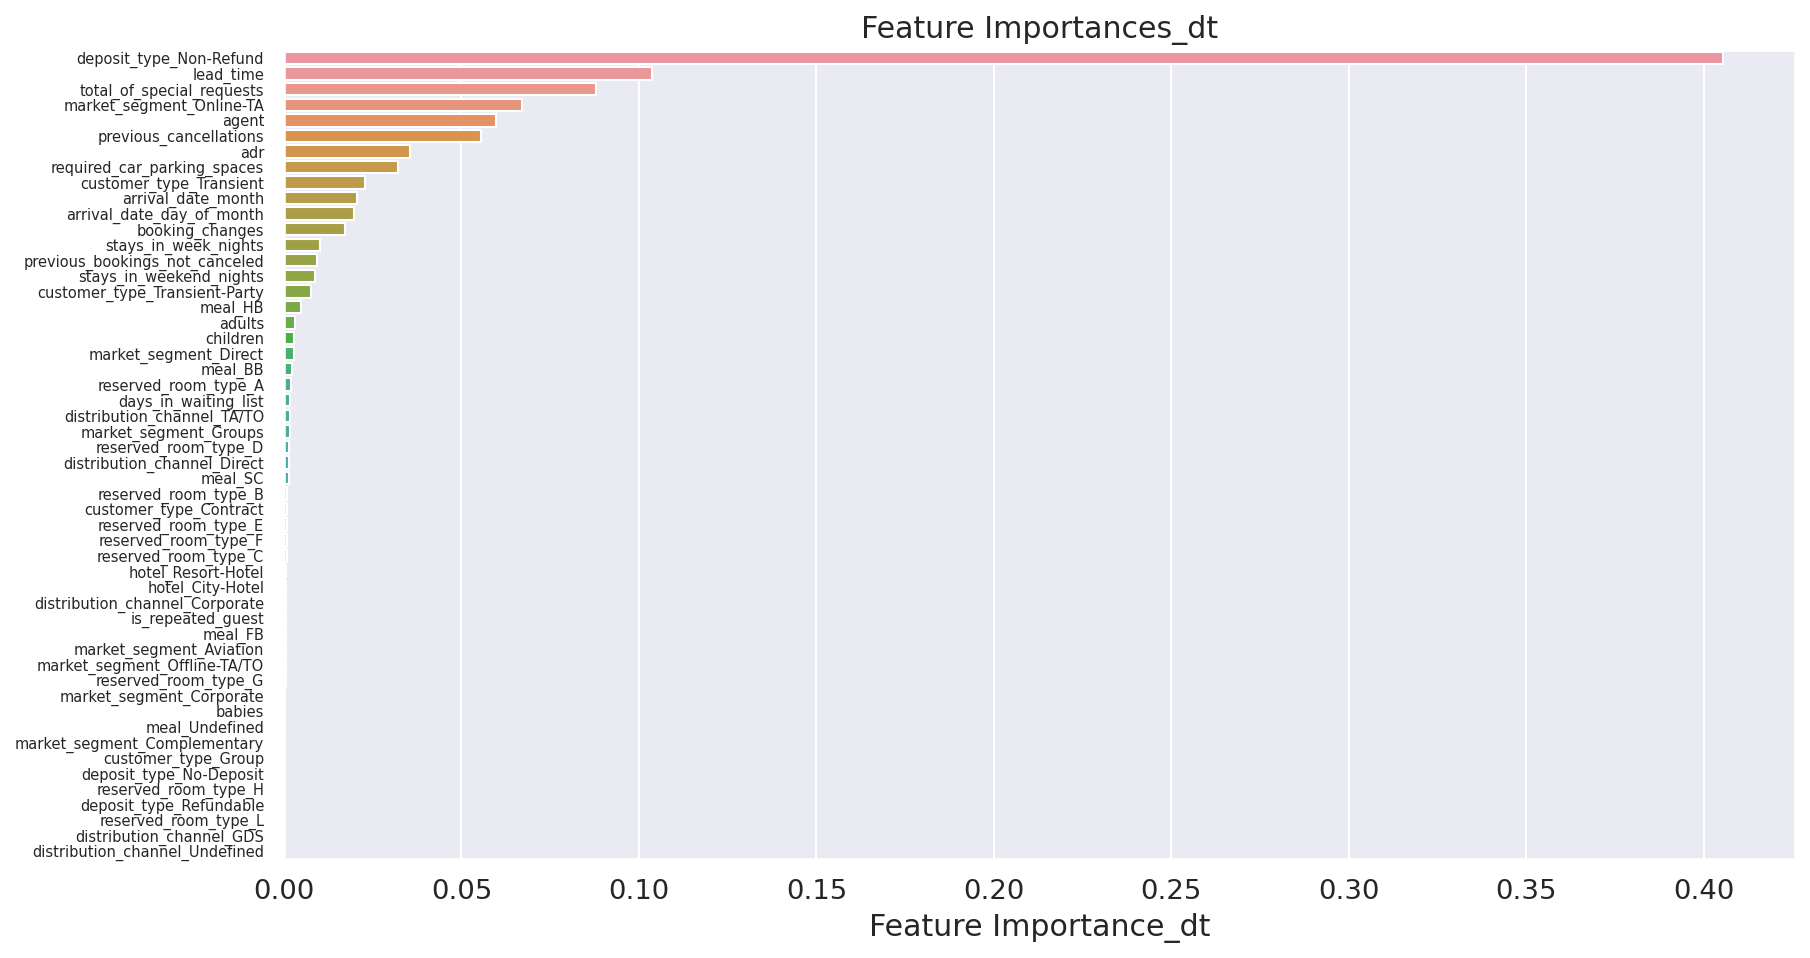

In [67]:
# Compute feature importances
feature_importances = best_dt.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(13, 7), dpi=150)
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices], )
plt.xlabel('Feature Importance_dt')
plt.title('Feature Importances_dt')
plt.yticks(fontsize=7)
plt.show()

### Tree visualization

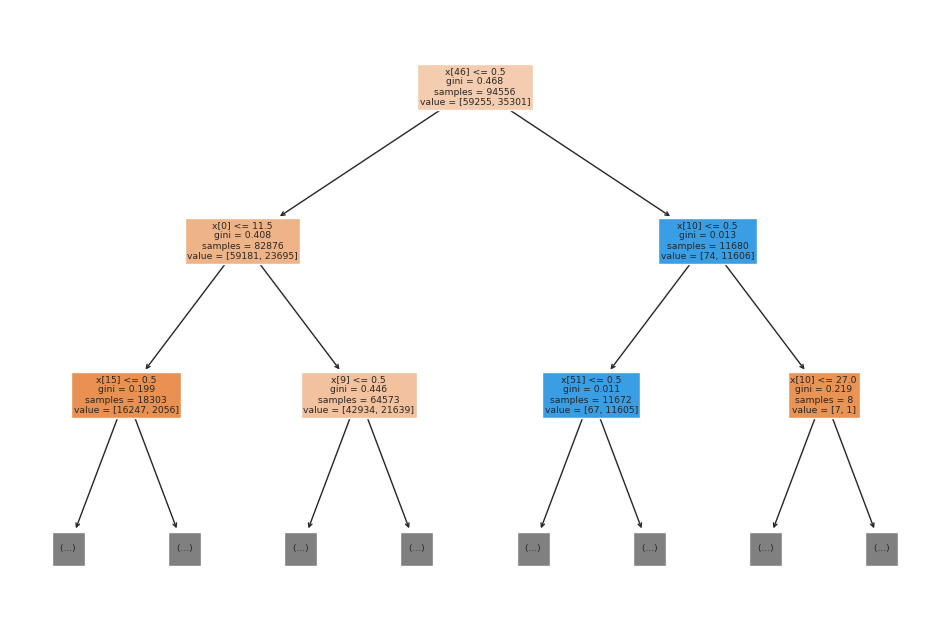

In [68]:
from sklearn import tree
import matplotlib.pyplot as plt


# Visualize the first four levels of the trained decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(best_dt, filled=True, max_depth=2)
plt.show()


## 3. Random Forest
Random forest is an ensable technique of pruned decision trees, that means that the same classifier is trained on n data sets with the same size, for each sample a decision tree is built based on a random set of m features, from all the models trained  the predictions are combined using majoroty voting ( hard voting)

We use this model because :
* is a parallelizable algorithm that can scale to large datasets.
* handles high-dimensional data and noisy data, and is robust to
overfitting


The problem that can arise using this model in this data set are:
* The model may not perform well on imbalanced datasets, as it may be biased towards the majority class ( but we have used the stratified split data)

In [69]:
# now we will do a random forest model first we start by defining the model constructor 
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

### TODO: to enable for report archive.

In [70]:
# lets set up a hyper parameter grid to tune the rf model 
"""
param_grid_rf = {
    'n_estimators': [100, 150],
    'criterion': ['entropy'],
    'max_depth': [16, 18],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    
}
"""

"\nparam_grid_rf = {\n    'n_estimators': [100, 150],\n    'criterion': ['entropy'],\n    'max_depth': [16, 18],\n    'min_samples_split': [2, 3, 4],\n    'min_samples_leaf': [1, 2, 3],\n    \n}\n"

In [71]:
# code to run fast
param_grid_rf = {
    'n_estimators': [150],
    'criterion': ['entropy'],
    'max_depth': [18],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    
}

In [72]:
# Using the tune_clf_hyp_param_scal function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyp_param_scal(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     59255
           1       0.90      0.73      0.80     35301

    accuracy                           0.87     94556
   macro avg       0.88      0.84      0.85     94556
weighted avg       0.87      0.87      0.86     94556


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.94      0.89     14814
           1       0.88      0.69      0.77      8825

    accuracy                           0.85     23639
   macro avg       0.86      0.82      0.83     23639
weighted avg       0.85      0.85      0.84     23639



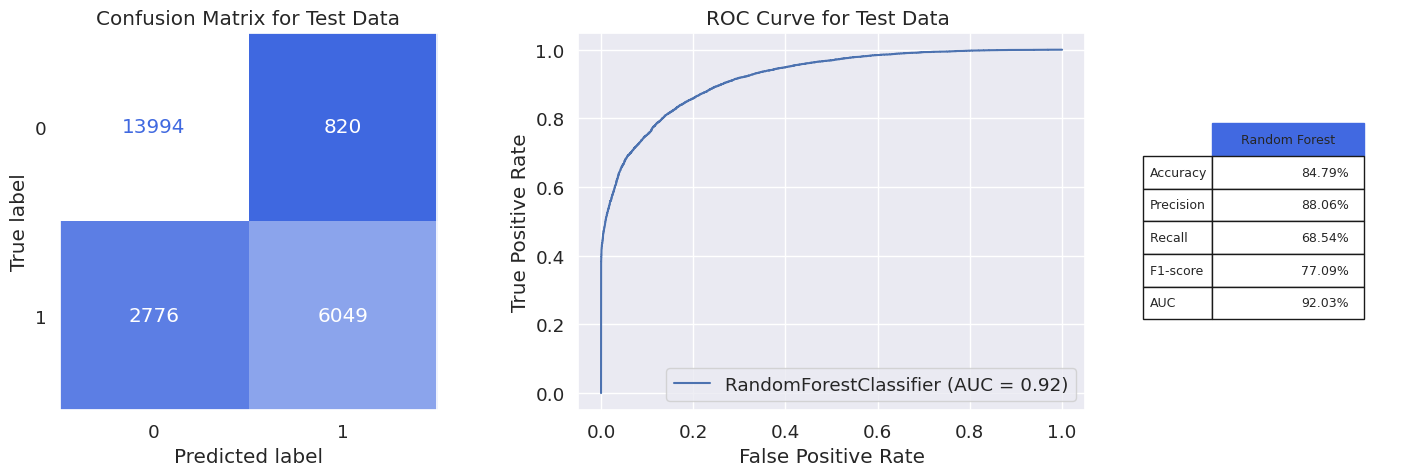

In [73]:
model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

In [74]:
# save the results of the rf moedel to further comparison
rf_result = metrics_calculator(best_rf, X_test, y_test, 'Random Forest')
rf_result

,Random Forest
Accuracy,84.79%
Precision,88.06%
Recall,68.54%
F1-score,77.09%
AUC,92.03%


### Analysis

**Accuracy** ``84,8%`` -  the correct predictions out of total predictions are 85% 

**Precision** ``88%`` - the instances that the model predicted as canceled which where actually canceled is 88%

**Recal** ``70%`` -  the model correctly identified only 70% of all true cancelations

**F1** ``77%`` - the harmonic mean between precision and recall is 77%

**AUC** ``92%`` - outstanding performance in distinguishing capability between the 2 classes 


As the results from the train and test sets do not differ that much, we can affirm that the model is not overfiting.

In [75]:
# lets compare the 2 models analized so far

results = pd.concat([dt_result, rf_result],axis=1)
results

,Decision Tree,Random Forest
Accuracy,83.39%,84.79%
Precision,82.41%,88.06%
Recall,70.56%,68.54%
F1-score,76.03%,77.09%
AUC,89.17%,92.03%


So far the Random Forest model has given us the best performance scores. Only in recall the decision tree is better

### Feature importance:

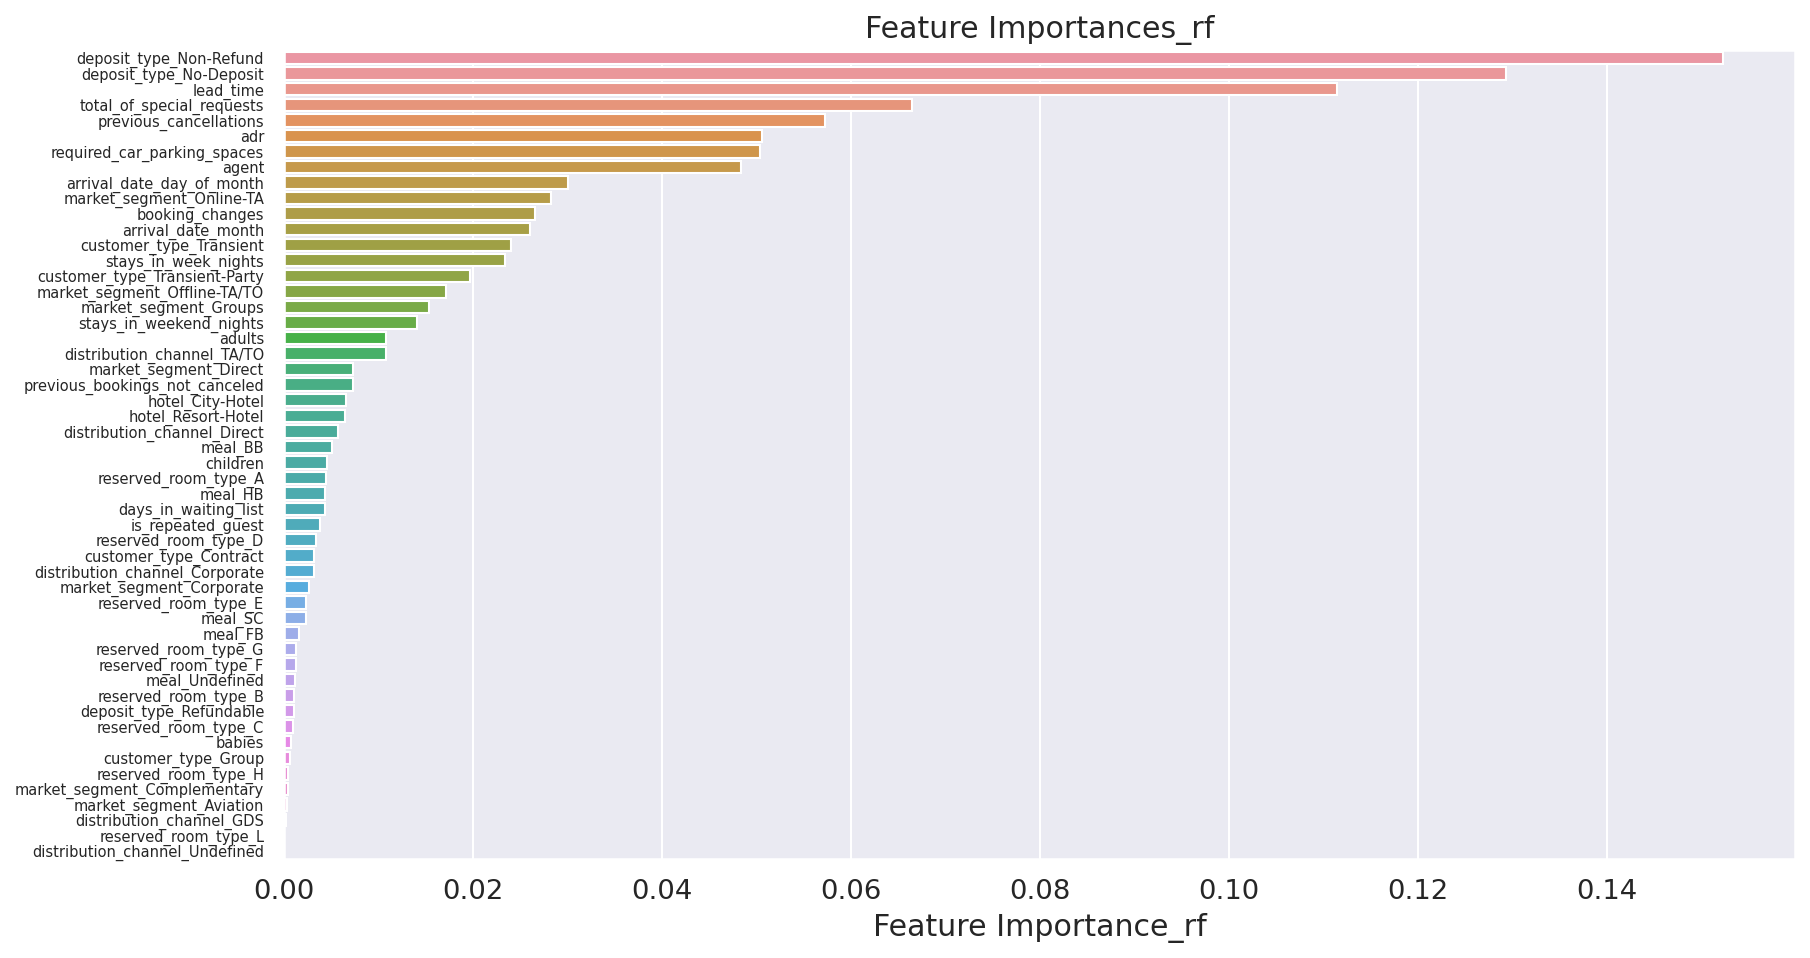

In [76]:
# since random forest is as the name indicate a tree based model lets compute the feature importance
# Compute feature importances
feature_importances = best_rf.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(13, 7), dpi=150)
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices], )
plt.xlabel('Feature Importance_rf')
plt.title('Feature Importances_rf')
plt.yticks(fontsize=7)
plt.show()

#### Analysis of feature importance:

The ``deposit_type`` impacts the classification the most, followed by the ``lead_time`` which is the time interval that goes from the booking reservation and the arrival day. ``total_of_special_requests`` and ``previous_cancelations``. 

This order of importance is expected: as one makes a non refundable booking, they will not want to lose the money. Exception being when a customer takes out a holiday insurance that covers the costs of cancelations. As we do not have informations about insurances, we conclude with that.

Lead time can be understood as: the longer the time between reservation and checkin, the more uncertaitnty and the more events can happen in between. According to research, this also gives people more time to find a better deal elsewhere and cancel.

The number of special requests can be interpreted as an investment on behalf of the customer, in time spend and money invested, therefore one is less likely to cancel. It could also be that be that only this hotel can accomodate these requests.

Previous cancellations are a good predictor as they signal a historic pattern in customer behavior.

## 4. GradientBoostingClassifier (XGBoost)

XGBoost is an optimized gradient boosting algorithm that is widely used for binary classification tasks. It is particularly effective when dealing with datasets that have a large number of features (columns) and a substantial number of entries (rows). 

It employs an ensemble of decision trees, where each tree is built sequentially to correct the mistakes made by the previous trees. This iterative process helps to improve the model's predictive performance.

XGBoost offers several advantages for binary classification tasks. It can handle missing values, automatically handle feature interactions, and provide feature importance rankings.

In [77]:
# Define the model xgboost model 
xgb_base = xgb.XGBClassifier(
    use_label_encoder=False, # already encoded variables and to avoid warnings
    criterion='log_loss', # better for binary classification
    random_state=42
)

### TODO: to enable for report archive.

In [78]:
#define the parameter grid using the most important parameters
"""param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1,(y_train == 0).sum() / (y_train == 1).sum()],
    'n_estimators': [100, 200, 300]
}
"""

"param_grid_xgb = {\n    'learning_rate': [0.01, 0.05, 0.1],\n    'max_depth': [3, 5, 7],\n    'subsample': [0.6, 0.8, 1.0],\n    'colsample_bytree': [0.6, 0.8, 1.0],\n    'scale_pos_weight': [1,(y_train == 0).sum() / (y_train == 1).sum()],\n    'n_estimators': [100, 200, 300]\n}\n"

In [79]:
# fast code for kaggle/local pc
param_grid_xgb = {
    'learning_rate': [0.1],
    'max_depth': [7],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'scale_pos_weight': [1.678564346619076],
    'n_estimators': [300]
}



In [80]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyp_param_scal(xgb_base, param_grid_xgb, X_train, y_train)
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:20:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:20:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:20:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:20:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:20:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn

XGBoost Optimal Hyperparameters: 
 {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 1.678564346619076, 'subsample': 0.8}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     59255
           1       0.83      0.85      0.84     35301

    accuracy                           0.88     94556
   macro avg       0.87      0.87      0.87     94556
weighted avg       0.88      0.88      0.88     94556


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     14814
           1       0.79      0.80      0.80      8825

    accuracy                           0.85     23639
   macro avg       0.84      0.84      0.84     23639
weighted avg       0.85      0.85      0.85     23639



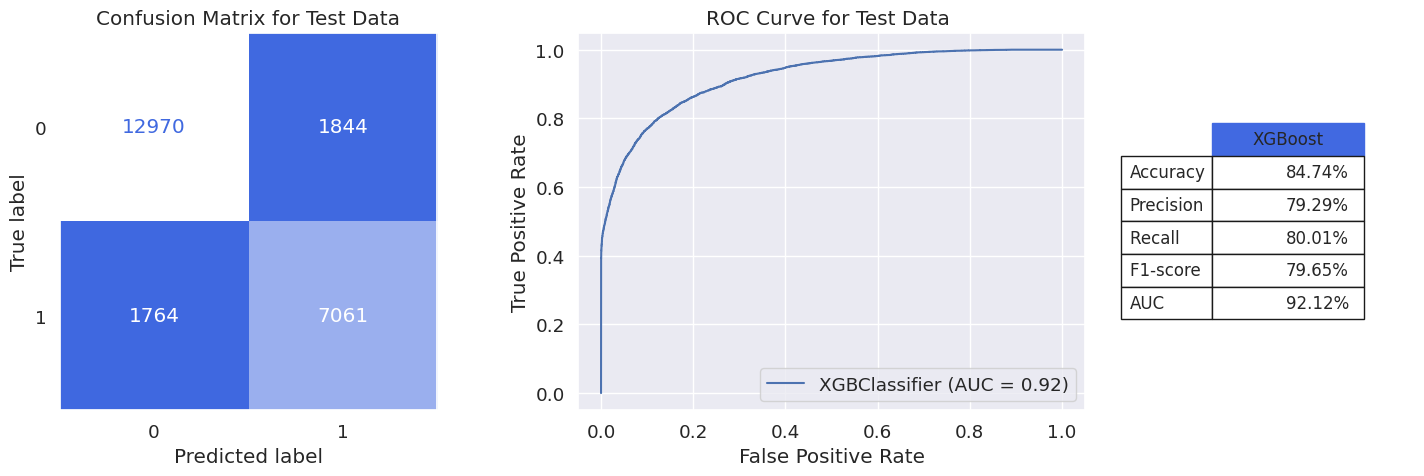

In [81]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

In [82]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(best_xgb, X_test, y_test, 'XGBoost')
xgb_result

,XGBoost
Accuracy,84.74%
Precision,79.29%
Recall,80.01%
F1-score,79.65%
AUC,92.12%


### Analysis

**Accuracy** ``85%`` -  the correct predictions out of total predictions are 85% 

**Precision** ``79%`` - the instances that the model predicted as canceled which where actually canceled is 79%

**Recal** ``80%`` -  the model correctly identified only 80% of all actual cancelations

**F1** ``80%`` - the harmonic mean between precision and recall is 80%

**AUC** ``92%`` - great performance in distinguishing capability between the 2 classes 

So far, the tree based models performed better.

## Feature importance:

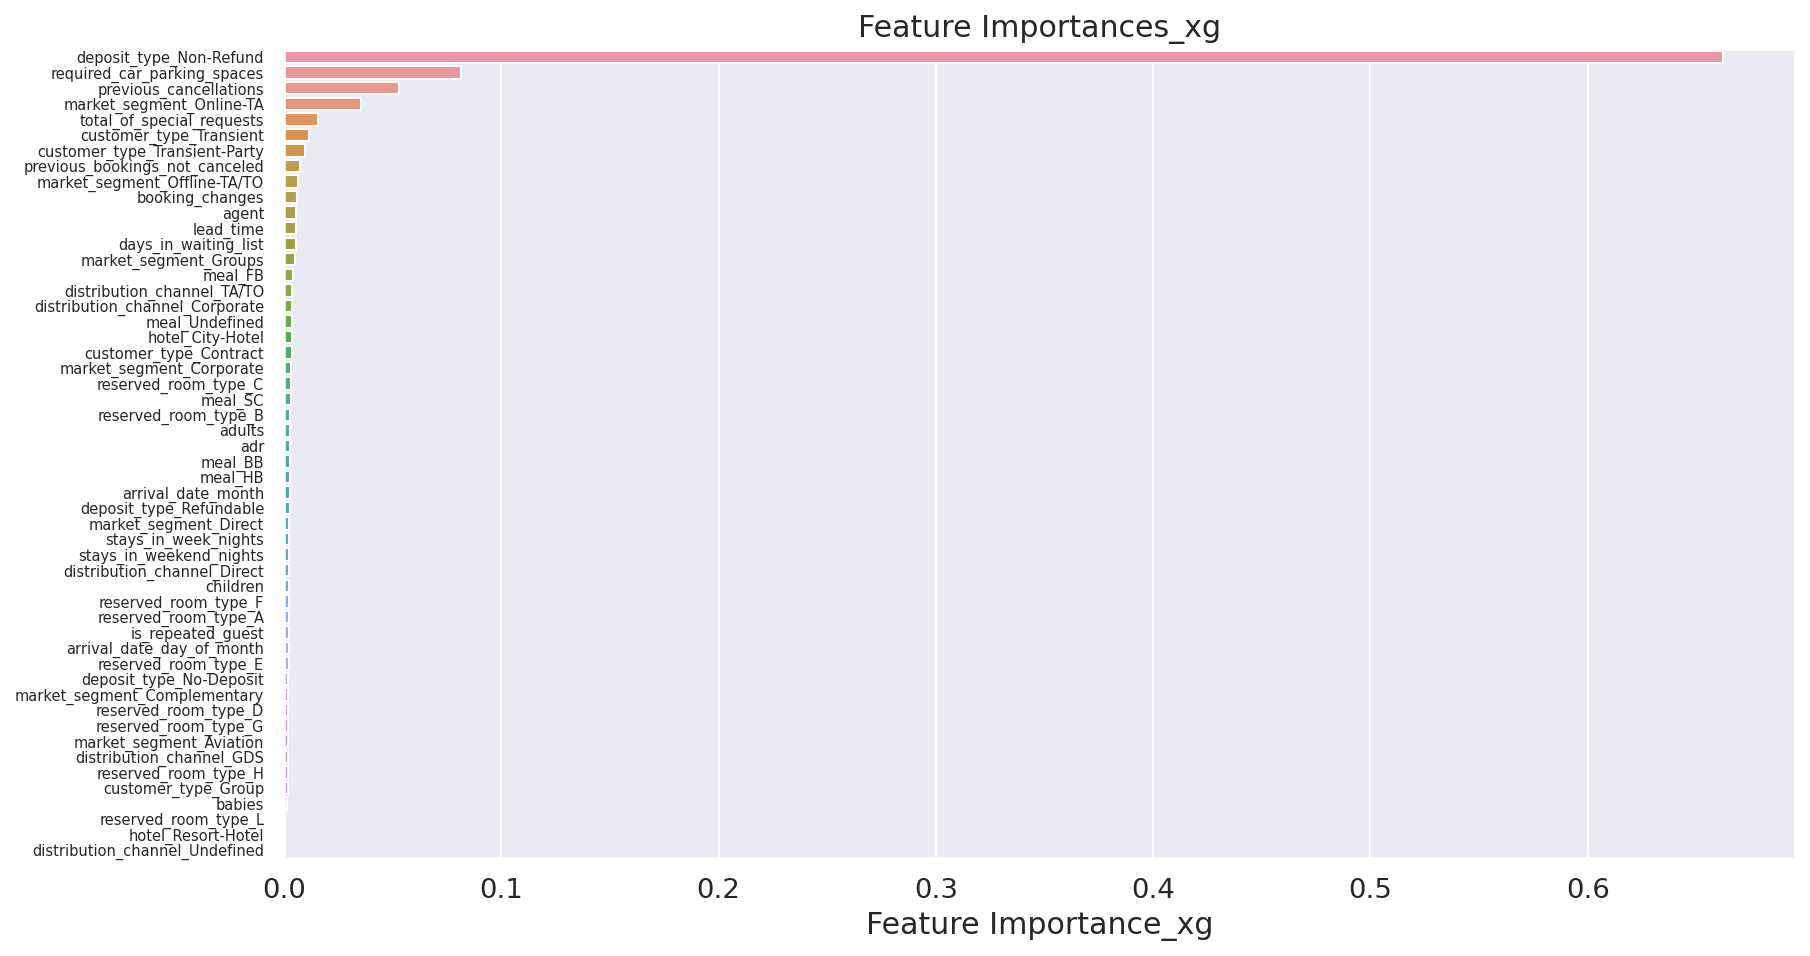

In [83]:

# Compute feature importances
feature_importances = best_xgb.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(13, 7), dpi=150)
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices])
plt.xlabel('Feature Importance_xg')
plt.title('Feature Importances_xg')
plt.yticks(fontsize=7)
plt.show()



#### Analysis of feature importance:
As it can be seen the ``deposit_type_non_refund`` is the most important feature in predicting whether a booking will be canceled or not (just like in the random forest model).

We do not have a good explanation for the relative importance of `required_car_parking_spaces`

``previoust_cancelations`` and ``total_of_special_requests`` are also important in this model just like in the random forest, this is a good sign showing consistency of the features importance 

# Limitations

TODO...

# Conclusion

TODO...

In [84]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([lr_result, dt_result, rf_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score (class 1) values
results.sort_values(by='F1-score ', ascending=False, inplace=True)

# Color the F1-score column
results.style.map(lambda x: 'background-color: royalblue', subset='F1-score ')

,Accuracy,Precision,Recall,F1-score,AUC
XGBoost,84.74%,79.29%,80.01%,79.65%,92.12%
Random Forest,84.79%,88.06%,68.54%,77.09%,92.03%
Decision Tree,83.39%,82.41%,70.56%,76.03%,89.17%
Logistic Regression,80.56%,83.15%,60.1%,69.77%,85.05%


To conclude, the best performing model has been XGBoost in the f1 score (the metric we consider most important). 

It also scores best for recall (by a large margin) and has the highest AUC score, meaning it can distunguish between the two classes.